# Compute precise decomposition of exponential and Matérn kernel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kl_decomposition import error_estimates, misc

all_kernels = {}
all_a, all_b, all_vals = misc.get_kl_decomp("data/exp.json")
all_kernels["exp"] = {"all_a": all_a, "all_b": all_b, "all_vals": all_vals}
all_a, all_b, all_vals = misc.get_kl_decomp("data/matern.json")
all_kernels["matern"] = {"all_a": all_a, "all_b": all_b, "all_vals": all_vals}
all_a, all_b, all_vals = misc.get_kl_decomp("data/powexp06.json")
all_kernels["powexp06"] = {"all_a": all_a, "all_b": all_b, "all_vals": all_vals}
all_a, all_b, all_vals = misc.get_kl_decomp("data/rq.json")
all_kernels["rq"] = {"all_a": all_a, "all_b": all_b, "all_vals": all_vals}
all_a, all_b, all_vals = misc.get_kl_decomp("data/cauchy.json")
all_kernels["cauchy"] = {"all_a": all_a, "all_b": all_b, "all_vals": all_vals}

Loading decomposition from data/exp.json...
Loading decomposition from data/matern.json...
Loading decomposition from data/powexp06.json...
Loading decomposition from data/rq.json...
Loading decomposition from data/cauchy.json...


In [4]:
kernels = {"exp": lambda x, y: np.exp(-np.abs(x - y)),
           "matern": lambda x, y: (1 + np.sqrt(5) * np.abs(x - y) + (5 / 3) * np.abs(x - y)**2) * np.exp(-np.sqrt(5) * np.abs(x - y)),
           "powexp06": lambda x, y: np.exp(- np.abs(x - y) ** 0.6),
           "rq": lambda x, y: (1 + (np.abs(x - y)**2) / 2) ** -1,
           "cauchy": lambda x, y: (1 + np.abs(x - y)) ** -1}

tols = [1e-3, 1e-6]
degrees = np.arange(1, 200, 1)
decomp_all = {}
error_all = {}
for kernel in kernels.keys():
    print(f"Processing kernel: {kernel}")
    for tol in tols:
        print(f"  Tolerance: {tol}")
        all_a, all_b, all_vals = misc.get_decomp_at_tol(all_kernels[kernel], tol)
        a_coeff = all_a
        b_coeff = np.exp(all_b)
        A_all = misc.get_kl_decomp_gal(b_coeff, comp_degree=200, quad=400,g=4)
        errors = []
        for comp_degree in degrees:
            print(f"    Component degree: {comp_degree}")
            lams, eigvecs = misc.get_kl_decomp_from_gal_to_operators(
                a_coeff, A_all, comp_degree=comp_degree, N_eval=1000)
            decomp_all[(kernel, tol, comp_degree)] = {"lambdas": lams, "phis": eigvecs}
            err_check = error_estimates.l2_error_tri_quad(kernels[kernel],
                                                          decomp_all[(kernel, tol, comp_degree)]["lambdas"],
                                                          decomp_all[(kernel, tol, comp_degree)]["phis"],
                                                          n_outer=30, n_inner=30)
            errors.append(err_check)
        error_all[(kernel, tol)] = errors

Processing kernel: exp
  Tolerance: 0.001
Processing b=2.596e-01.
Processing b=1.406e+00.
Processing b=6.887e+00.
Processing b=4.229e+01.
Processing b=5.140e+02.
    Component degree: 1
    Component degree: 2
    Component degree: 3
    Component degree: 4
    Component degree: 5
    Component degree: 6
    Component degree: 7
    Component degree: 8
    Component degree: 9
    Component degree: 10
    Component degree: 11
    Component degree: 12
    Component degree: 13
    Component degree: 14
    Component degree: 15
    Component degree: 16
    Component degree: 17
    Component degree: 18
    Component degree: 19
    Component degree: 20
    Component degree: 21
    Component degree: 22
    Component degree: 23
    Component degree: 24
    Component degree: 25
    Component degree: 26
    Component degree: 27
    Component degree: 28
    Component degree: 29
    Component degree: 30
    Component degree: 31
    Component degree: 32
    Component degree: 33
    Component degree: 

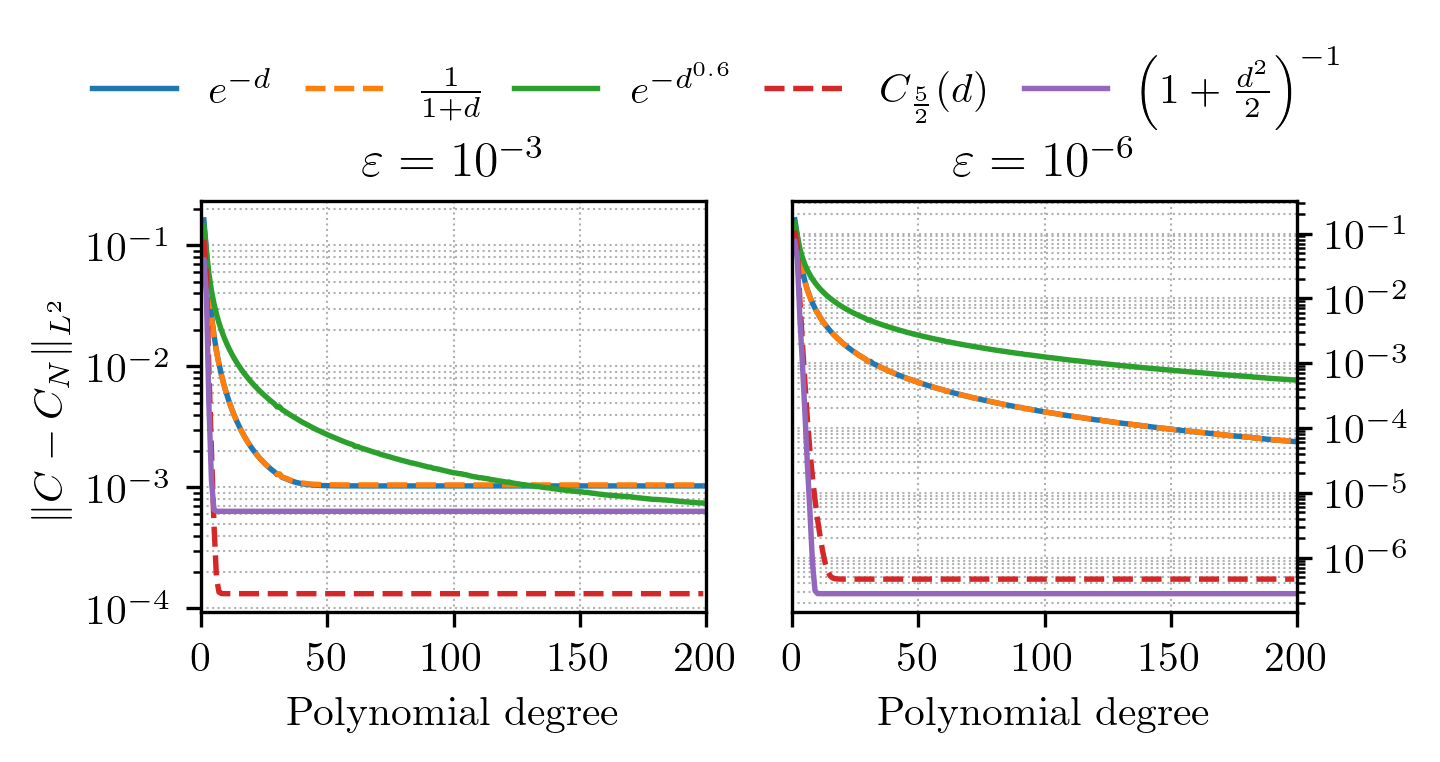

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, AutoMinorLocator

# --- Plot styling ---
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# --- Ordered kernels to match legend ---
ordered_kernels = ["exp", "cauchy", "powexp06", "matern", "rq"]

label_map = {
    "exp": r"$e^{-d}$",
    "cauchy": r"$\frac{1}{1+d}$",
    "powexp06": r"$e^{-d^{0.6}}$",
    "matern": r"$C_{\frac{5}{2}}(d)$",
    "rq": r"$\left(1 + \frac{d^2}{2}\right)^{-1}$",
}
colors = {
    "exp": "tab:blue",
    "cauchy": "tab:orange",
    "powexp06": "tab:green",
    "matern": "tab:red",
    "rq": "tab:purple"
}
linestyles = {
    "exp": "-",
    "cauchy": "--",
    "powexp06": "-",
    "matern": "--",
    "rq": "-",
}
markers = {
    "exp": "none",
    "cauchy": "none",
    "powexp06": "none",
    "matern": "none",
    "rq": "none"
}
tols = [1e-3, 1e-6]

# --- Create figure with two separate y-axes ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4.9, 2.1), dpi=300, sharex=True)

for i, (ax, tol) in enumerate(zip(axes, tols)):
    for kernel in ordered_kernels:
        errs = error_all[(kernel, tol)]
        ax.plot(degrees, errs,
                label=label_map[kernel],
                color=colors[kernel],
                linestyle=linestyles[kernel],
                marker=markers[kernel],
                markersize=4,
                linewidth=1.3)

    ax.set_yscale("log")
    ax.set_xlim(0, 200)
    ax.set_xticks(np.arange(0, 201, 50))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=50))
    ax.tick_params(which='minor', length=2)

    ax.set_xlabel("Polynomial degree")
    if i == 0:
        ax.set_ylabel(r"$\|C - C_N\|_{L^2}$")
    else:
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        # No label on the right
    ax.set_title(rf"$\varepsilon = 10^{{{int(np.log10(tol))}}}$")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5)

# --- Shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           ncol=5,
           frameon=False,
           bbox_to_anchor=(0.5, 1.22),
           columnspacing=0.8)

fig.tight_layout(rect=[0, 0, 1, 1.08])  # leave space above for legend
fig.savefig("kl_decomp_errors.pdf", bbox_inches="tight", transparent=True, pad_inches=0)
plt.show()

In [36]:
def format_scientific(val):
    """Format float in LaTeX scientific notation with 4 significant digits."""
    if val == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(abs(val))))
    coeff = val / 10**exp
    return rf"${coeff:.1g} \cdot 10^{{{exp}}}$"


tols = [1e-2, 1e-3, 1e-4, 1e-6]

# --- LaTeX label for kernels ---
label_map = {
    "exp": r"$e^{-d}$",
    "cauchy": r"$\frac{1}{1+d}$",
    "powexp06": r"$e^{-d^{0.6}}$",
    "matern": r"$C_{\frac{5}{2}}(d)$",
    "rq": r"$\left(1 + \frac{d^2}{2}\right)^{-1}$",
}

# --- Collect data: kernel → tol → (n_terms, error) ---
row_data = {}

for kernel in kernels.keys():
    kernel_data = {}
    for tol in tols:
        all_a, all_b, all_vals = misc.get_decomp_at_tol(all_kernels[kernel], tol)
        n_terms = len(all_b)
        err = format_scientific(all_vals)
        kernel_data[tol] = (n_terms, err)
    row_data[kernel] = kernel_data

# --- Print LaTeX table ---
n_cols = 1 + len(tols) * 2
print(r"\begin{tabular}{" + "l " + " ".join(["rr"] * len(tols)) + r"}")
print(r"\toprule")

# Header: first row
header = r"\multirow{2}{*}{Kernel} "
for tol in tols:
    tol_tex = rf"$\varepsilon = 10^{{{int(np.log10(tol))}}}$"
    header += f"& \\multicolumn{{2}}{{c}}{{{tol_tex}}} "
header += r"\\"
print(header)

# Header: second row
subheader = " & " + " & ".join([r"\# Terms & Error"] * len(tols)) + r" \\"
print(subheader)

print(r"\midrule")

# Table body
for kernel in kernels.keys():
    label = label_map[kernel]
    row = [label]
    for tol in tols:
        n_terms, err = row_data[kernel][tol]
        row.extend([str(n_terms), err])
    print(" & ".join(row) + r" \\")

print(r"\bottomrule")
print(r"\end{tabular}")

\begin{tabular}{l rr rr rr rr}
\toprule
\multirow{2}{*}{Kernel} & \multicolumn{2}{c}{$\varepsilon = 10^{-2}$} & \multicolumn{2}{c}{$\varepsilon = 10^{-3}$} & \multicolumn{2}{c}{$\varepsilon = 10^{-4}$} & \multicolumn{2}{c}{$\varepsilon = 10^{-6}$} \\
 & \# Terms & Error & \# Terms & Error & \# Terms & Error & \# Terms & Error \\
\midrule
$e^{-d}$ & 3 & $6 \cdot 10^{-3}$ & 5 & $9 \cdot 10^{-4}$ & 8 & $9 \cdot 10^{-5}$ & 16 & $8 \cdot 10^{-7}$ \\
$C_{\frac{5}{2}}(d)$ & 2 & $2 \cdot 10^{-3}$ & 3 & $2 \cdot 10^{-4}$ & 4 & $2 \cdot 10^{-5}$ & 6 & $5 \cdot 10^{-7}$ \\
$e^{-d^{0.6}}$ & 4 & $5 \cdot 10^{-3}$ & 7 & $6 \cdot 10^{-4}$ & 11 & $6 \cdot 10^{-5}$ & 20 & $1 \cdot 10^{-6}$ \\
$\left(1 + \frac{d^2}{2}\right)^{-1}$ & 2 & $1e+01 \cdot 10^{-4}$ & 2 & $1e+01 \cdot 10^{-4}$ & 3 & $2 \cdot 10^{-5}$ & 4 & $4 \cdot 10^{-7}$ \\
$\frac{1}{1+d}$ & 3 & $6 \cdot 10^{-3}$ & 5 & $9 \cdot 10^{-4}$ & 8 & $9 \cdot 10^{-5}$ & 16 & $8 \cdot 10^{-7}$ \\
\bottomrule
\end{tabular}
